In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **IMPORTS AND CONFIG** (cell 1)

In [2]:
import logging
from pathlib import Path
from typing import Dict, Tuple, Any, Optional, List
import json
import os
import cv2
import numpy as np
from tqdm import tqdm
from datetime import datetime
import shutil
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
import yaml
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


# Setup logging (Senior-level: Proper logging instead of print)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('/content/data_labeling.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ============================================================================
# COLAB PATH CONFIGURATION
# ============================================================================
# Choose ONE of the following options:

# OPTION 1: Data in Google Drive (most common)
USE_DRIVE = True  # Set to False if data is uploaded to Colab

if USE_DRIVE:
    # Paths for Google Drive
    DRIVE_BASE = Path("/content/drive/MyDrive")
    # Update this path to match your Drive folder structure
    # Example: DRIVE_BASE / "ai-banana-earlystage" / "Data" / "Sigatoka pics"
    DATA_DIR = DRIVE_BASE / "Machine_Learning" / "Sigatoka pics"
    OUTPUT_DIR = DRIVE_BASE / "Machine_Learning" / "Data Labeling"

    print("📁 Using Google Drive paths")
    print(f"   Data: {DATA_DIR}")
    print(f"   Output: {OUTPUT_DIR}")
else:
    # OPTION 2: Data uploaded to Colab (use /content/)
    DATA_DIR = Path("/content/Data/Sigatoka pics")
    OUTPUT_DIR = Path("/content/Data Labeling")

    print("📁 Using Colab workspace paths")
    print(f"   Data: {DATA_DIR}")
    print(f"   Output: {OUTPUT_DIR}")

# Validate paths exist
if not DATA_DIR.exists():
    logger.warning(f"⚠️  Data directory not found: {DATA_DIR}")
    print(f"\n⚠️  WARNING: Data directory not found!")
    print(f"   Please check the path: {DATA_DIR}")
    print(f"   Update DATA_DIR in this cell to match your folder structure")
else:
    print(f"✅ Data directory found: {DATA_DIR}")

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Output directory: {OUTPUT_DIR}")
print(f"✅ Output directory ready: {OUTPUT_DIR}")

# Class labels mapping
CLASS_LABELS = {
    "Healthy": "Healthy",
    "Stage1": "Stage1",
    "Stage2": "Stage2",
    "Stage3": "Stage3",
    "Stage4": "Stage4",
    "Stage5": "Stage5",
    "Stage6": "Stage6"
}

# Class color mapping for visualizations
CLASS_COLORS = {
    "Healthy": "#006400",      # Dark Green
    "Stage1": "#00FF00",        # Green
    "Stage2": "#90EE90",        # Light Green
    "Stage3": "#ADFF2F",        # Yellow Green
    "Stage4": "#FFFF00",        # Yellow
    "Stage5": "#FFA500",        # Orange
    "Stage6": "#FF0000"         # Red
}

# Class colors as RGB tuples (for matplotlib/OpenCV)
CLASS_COLORS_RGB = {
    "Healthy": (0, 100, 0),         # Dark Green (BGR for OpenCV)
    "Stage1": (0, 255, 0),          # Green
    "Stage2": (144, 238, 144),      # Light Green
    "Stage3": (47, 255, 173),       # Yellow Green
    "Stage4": (0, 255, 255),        # Yellow
    "Stage5": (0, 165, 255),        # Orange
    "Stage6": (0, 0, 255)           # Red
}

# Image quality thresholds
QUALITY_THRESHOLDS = {
    "min_resolution": (256, 256),  # Minimum width, height
    "max_blur_threshold": 100.0,  # Laplacian variance threshold (lower = blurrier)
    "min_brightness": 20,  # Minimum average brightness (0-255)
    "max_brightness": 240,  # Maximum average brightness (0-255)
    "min_file_size_kb": 50,  # Minimum file size in KB
    "max_file_size_mb": 10,  # Maximum file size in MB
}

# Supported image formats
SUPPORTED_FORMATS = [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]

# Metadata fields to extract
METADATA_FIELDS = [
    "image_path",
    "class_label",
    "width",
    "height",
    "file_size_kb",
    "blur_score",
    "brightness_score",
    "quality_status",
    "timestamp",
    "source_folder"
]

print("✓ Configuration loaded")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

print("\n🎨 Class Color Mapping:")
for class_name, color in CLASS_COLORS.items():
    print(f"   {class_name}: {color}")

# Utility function to draw bounding box on image with class color
def draw_bounding_box(image, class_label, bbox=None, thickness=5, add_label=True):
    """
    Draw bounding box on image with class color.

    Args:
        image: Image as numpy array (BGR format for OpenCV)
        class_label: Class label (e.g., 'Stage1', 'Healthy')
        bbox: Bounding box as (x1, y1, x2, y2) or None for full image
        thickness: Line thickness for bounding box
        add_label: Whether to add class label text on image

    Returns:
        Image with bounding box drawn
    """
    img_copy = image.copy()
    h, w = img_copy.shape[:2]

    # Get class color (BGR format for OpenCV)
    class_color_bgr = CLASS_COLORS_RGB.get(class_label, (0, 0, 0))

    # If bbox is None, draw around entire image (for whole-image classification)
    if bbox is None:
        pt1 = (0, 0)
        pt2 = (w-1, h-1)
    else:
        x1, y1, x2, y2 = bbox
        pt1 = (int(x1), int(y1))
        pt2 = (int(x2), int(y2))

    # Draw bounding box
    cv2.rectangle(img_copy, pt1, pt2, class_color_bgr, thickness=thickness)

    # Add class label text
    if add_label:
        label_x, label_y = pt1[0] + 10, pt1[1] + 30
        cv2.putText(img_copy, class_label, (label_x, label_y),
                   cv2.FONT_HERSHEY_BOLD, 1.2, class_color_bgr, 2)

    return img_copy

print("\n✓ Utility function 'draw_bounding_box()' loaded")


📁 Using Google Drive paths
   Data: /content/drive/MyDrive/Machine_Learning/Sigatoka pics
   Output: /content/drive/MyDrive/Machine_Learning/Data Labeling
✅ Data directory found: /content/drive/MyDrive/Machine_Learning/Sigatoka pics
✅ Output directory ready: /content/drive/MyDrive/Machine_Learning/Data Labeling
✓ Configuration loaded
Data directory: /content/drive/MyDrive/Machine_Learning/Sigatoka pics
Output directory: /content/drive/MyDrive/Machine_Learning/Data Labeling

🎨 Class Color Mapping:
   Healthy: #006400
   Stage1: #00FF00
   Stage2: #90EE90
   Stage3: #ADFF2F
   Stage4: #FFFF00
   Stage5: #FFA500
   Stage6: #FF0000

✓ Utility function 'draw_bounding_box()' loaded


# **IMAGE QUALITY ASSESSOR** (cell 2)

In [3]:

logger = logging.getLogger(__name__)
class ImageQualityAssessor:


    def __init__(self,
                 min_resolution: Tuple[int, int] = (256, 256),
                 max_blur_threshold: float = 100.0,
                 min_brightness: int = 20,
                 max_brightness: int = 240):
        """
        Initialize quality assessor with thresholds.

        Args:
            min_resolution: Minimum (width, height) in pixels
            max_blur_threshold: Laplacian variance threshold (lower = blurrier)
            min_brightness: Minimum average brightness (0-255)
            max_brightness: Maximum average brightness (0-255)

        Raises:
            ValueError: If thresholds are invalid
        """
        # Input validation (Senior-level)
        if min_resolution[0] < 0 or min_resolution[1] < 0:
            raise ValueError("Resolution must be positive")
        if max_blur_threshold < 0:
            raise ValueError("Blur threshold must be positive")
        if not (0 <= min_brightness < max_brightness <= 255):
            raise ValueError("Brightness thresholds must be in range [0, 255]")

        self.min_resolution = min_resolution
        self.max_blur_threshold = max_blur_threshold
        self.min_brightness = min_brightness
        self.max_brightness = max_brightness

        logger.info(f"ImageQualityAssessor initialized with thresholds: {self.__dict__}")

    def check_blur(self, image: np.ndarray) -> Dict[str, Any]:
        """
        Assess image blur using Laplacian variance.
        Args:
            image: Input image as numpy array

        Returns:
            Dict with 'score' (higher = sharper) and 'status' ('good'/'blurry'/'invalid')
        """
        if image is None or not isinstance(image, np.ndarray) or image.size == 0:
            logger.warning("Invalid image provided for blur check")
            return {"score": 0.0, "status": "invalid"}

        try:
            # Convert to grayscale if needed (Senior-level: Handle different formats)
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            elif len(image.shape) == 2:
                gray = image
            else:
                logger.warning(f"Unexpected image shape: {image.shape}")
                return {"score": 0.0, "status": "invalid"}

            # Calculate Laplacian variance (Senior-level: Efficient computation)
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            status = "good" if laplacian_var >= self.max_blur_threshold else "blurry"

            return {"score": float(laplacian_var), "status": status}
        except Exception as e:
            logger.error(f"Error in blur check: {e}", exc_info=True)
            return {"score": 0.0, "status": "error", "error": str(e)}

    def check_brightness(self, image: np.ndarray) -> Dict[str, float]:
        """Assess image brightness"""
        if image is None or image.size == 0:
            return {"score": 0.0, "status": "invalid"}

        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        avg_brightness = np.mean(gray)

        if avg_brightness < self.min_brightness:
            status = "too_dark"
        elif avg_brightness > self.max_brightness:
            status = "too_bright"
        else:
            status = "good"

        return {"score": float(avg_brightness), "status": status}

    def check_resolution(self, image: np.ndarray) -> Dict[str, Any]:
        """
        Check image resolution.
        Args:
            image: Input image as numpy array
        Returns:
            Dict with width, height, and status
        """
        if image is None or not isinstance(image, np.ndarray) or image.size == 0:
            return {"width": 0, "height": 0, "status": "invalid"}

        try:
            height, width = image.shape[:2]
            min_w, min_h = self.min_resolution
            status = "good" if width >= min_w and height >= min_h else "too_small"

            return {"width": int(width), "height": int(height), "status": status}
        except Exception as e:
            logger.error(f"Error in resolution check: {e}", exc_info=True)
            return {"width": 0, "height": 0, "status": "error", "error": str(e)}

    def check_file_size(self, file_path: Path) -> Dict[str, Any]:
        """
        Check file size with proper error handling.
        Args:
            file_path: Path to file
        Returns:
            Dict with file size information
        """
        if not isinstance(file_path, Path):
            file_path = Path(file_path)

        try:
            if not file_path.exists():
                logger.warning(f"File not found: {file_path}")
                return {"size_bytes": 0, "size_kb": 0.0, "size_mb": 0.0, "status": "file_not_found"}

            size_bytes = os.path.getsize(file_path)
            size_kb = size_bytes / 1024
            size_mb = size_kb / 1024

            if size_kb < 50:
                status = "too_small"
            elif size_mb > 10:
                status = "too_large"
            else:
                status = "good"

            return {
                "size_bytes": int(size_bytes),
                "size_kb": round(size_kb, 2),
                "size_mb": round(size_mb, 2),
                "status": status
            }
        except OSError as e:
            logger.error(f"OS error checking file size for {file_path}: {e}")
            return {"size_bytes": 0, "size_kb": 0.0, "size_mb": 0.0, "status": f"error: {str(e)}"}
        except Exception as e:
            logger.error(f"Unexpected error checking file size: {e}", exc_info=True)
            return {"size_bytes": 0, "size_kb": 0.0, "size_mb": 0.0, "status": f"error: {str(e)}"}

    def assess_image(self, image_path: Path) -> Dict[str, Any]:
        """
        Args:
            image_path: Path to image file

        Returns:
            Dict with comprehensive quality metrics
        """
        if not isinstance(image_path, Path):
            image_path = Path(image_path)

        results = {
            "image_path": str(image_path),
            "file_exists": False,
            "readable": False,
            "overall_status": "unknown"
        }

        if not image_path.exists():
            logger.warning(f"Image file not found: {image_path}")
            results["overall_status"] = "file_not_found"
            return results

        results["file_exists"] = True
        file_size_info = self.check_file_size(image_path)
        results.update(file_size_info)

        try:
            # Senior-level: Use cv2.IMREAD_UNCHANGED to preserve image properties
            image = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
            if image is None:
                logger.warning(f"Cannot read image (may be corrupted): {image_path}")
                results["overall_status"] = "cannot_read"
                return results

            results["readable"] = True

            # Perform all quality checks
            resolution_info = self.check_resolution(image)
            results.update(resolution_info)

            blur_info = self.check_blur(image)
            results["blur_score"] = blur_info.get("score", 0.0)
            results["blur_status"] = blur_info.get("status", "unknown")

            brightness_info = self.check_brightness(image)
            results["brightness_score"] = brightness_info.get("score", 0.0)
            results["brightness_status"] = brightness_info.get("status", "unknown")

            # Aggregate issues (Senior-level: Structured issue tracking)
            issues = []
            if resolution_info.get("status") != "good":
                issues.append("resolution")
            if blur_info.get("status") not in ["good", "unknown"]:
                issues.append("blur")
            if brightness_info.get("status") not in ["good", "unknown"]:
                issues.append("brightness")
            if file_size_info.get("status") != "good":
                issues.append("file_size")

            if not issues:
                results["overall_status"] = "good"
            else:
                results["overall_status"] = f"issues: {', '.join(issues)}"
                results["issues"] = issues

            logger.debug(f"Quality assessment complete for {image_path.name}: {results['overall_status']}")

        except cv2.error as e:
            logger.error(f"OpenCV error processing {image_path}: {e}", exc_info=True)
            results["overall_status"] = f"opencv_error: {str(e)}"
            results["error"] = str(e)
        except Exception as e:
            logger.error(f"Unexpected error assessing {image_path}: {e}", exc_info=True)
            results["overall_status"] = f"error: {str(e)}"
            results["error"] = str(e)

        return results

logger.info("✓ ImageQualityAssessor class loaded")


# **Tile and Resizing**

In [4]:
def tile_and_resize_image(image_path, output_dir, class_label, tile_size=256, grid_cols=4, grid_rows=4):
    """
    Tile an image into smaller patches and resize each to specified size.

    Args:
        image_path: Path to source image
        output_dir: Directory to save tiled images
        class_label: Class label for the tiles
        tile_size: Final size of each tile (default: 256x256)
        grid_cols: Number of columns in grid (default: 4)
        grid_rows: Number of rows in grid (default: 4)

    Returns:
        List of paths to created tile files
    """
    # Read image
    img = cv2.imread(str(image_path))
    if img is None:
        logger.warning(f"Cannot read image: {image_path}")
        return []

    h, w = img.shape[:2]

    # Calculate tile dimensions before resizing
    tile_w = w / grid_cols
    tile_h = h / grid_rows

    tile_paths = []
    base_name = image_path.stem

    # Create tiles
    for row in range(grid_rows):
        for col in range(grid_cols):
            # Calculate tile coordinates
            x1 = int(col * tile_w)
            y1 = int(row * tile_h)
            x2 = int((col + 1) * tile_w)
            y2 = int((row + 1) * tile_h)

            # Extract tile
            tile = img[y1:y2, x1:x2]

            # Resize tile to target size (256x256)
            tile_resized = cv2.resize(tile, (tile_size, tile_size), interpolation=cv2.INTER_LINEAR)

            # Create output filename
            tile_filename = f"{class_label}_{base_name}_tile_{row}_{col}{image_path.suffix}"
            tile_path = output_dir / tile_filename

            # Save tile
            cv2.imwrite(str(tile_path), tile_resized)
            tile_paths.append(tile_path)

    return tile_paths

# Create tiled images directory
TILED_DIR = OUTPUT_DIR / 'tiled_images'
TILED_DIR.mkdir(parents=True, exist_ok=True)

print("="*60)
print("🖼️  TILING AND RESIZING IMAGES")
print("="*60)
print(f"\n📁 Source: {DATA_DIR}")
print(f"📁 Output: {TILED_DIR}")
print(f"📐 Tile size: 256x256")
print(f"📊 Grid: 4 columns × 4 rows = 16 tiles per image")
print(f"\n{'='*60}\n")

# Process each stage folder
stage_folders = [d for d in DATA_DIR.iterdir()
                 if d.is_dir() and any(key.lower() in d.name.lower()
                                     for key in CLASS_LABELS.keys())]

if not stage_folders:
    print(f"⚠️  No stage folders found in {DATA_DIR}")
else:
    total_tiles = 0
    all_tile_metadata = []

    for stage_folder in sorted(stage_folders):
        # Extract class label from folder name
        class_label = None
        for key, label in CLASS_LABELS.items():
            if key.lower() in stage_folder.name.lower():
                class_label = label
                break

        if not class_label:
            print(f"⚠️  Warning: Could not determine class for {stage_folder}")
            continue

        print(f"\n📁 Processing {stage_folder.name} -> Class: {class_label}")

        # Create class subdirectory for tiles
        class_tile_dir = TILED_DIR / class_label
        class_tile_dir.mkdir(exist_ok=True)

        # Get all image files
        image_files = []
        for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]:
            image_files.extend(stage_folder.glob(ext))

        if not image_files:
            print(f"  ⚠ No images found in {stage_folder}")
            continue

        # Process each image
        tiles_created = 0
        for img_path in tqdm(image_files, desc=f"Tiling {class_label}", leave=False):
            try:
                # Tile and resize image
                tile_paths = tile_and_resize_image(
                    image_path=img_path,
                    output_dir=class_tile_dir,
                    class_label=class_label,
                    tile_size=256,
                    grid_cols=4,
                    grid_rows=4
                )

                tiles_created += len(tile_paths)

                # Store metadata for each tile
                for tile_path in tile_paths:
                    all_tile_metadata.append({
                        'tile_path': str(tile_path),
                        'tile_name': tile_path.name,
                        'class_label': class_label,
                        'source_image': img_path.name,
                        'source_path': str(img_path)
                    })

            except Exception as e:
                logger.error(f"Error processing {img_path.name}: {e}")

        print(f"  ✅ Created {tiles_created} tiles from {len(image_files)} images")
        total_tiles += tiles_created

    print(f"\n{'='*60}")
    print(f"✅ TILING COMPLETE")
    print(f"{'='*60}")
    print(f"📊 Summary:")
    print(f"   Total tiles created: {total_tiles}")
    print(f"   Tiles per image: 16 (4×4 grid)")
    print(f"   Tile size: 256×256 pixels")
    print(f"   Output directory: {TILED_DIR}")
    print(f"{'='*60}\n")

    # Save tile metadata to CSV
    if all_tile_metadata:
        tiles_df = pd.DataFrame(all_tile_metadata)
        tiles_csv = TILED_DIR / 'tiles_metadata.csv'
        tiles_df.to_csv(tiles_csv, index=False)
        print(f"📄 Tile metadata saved: {tiles_csv}")
        print(f"   Total tiles: {len(tiles_df)}")

🖼️  TILING AND RESIZING IMAGES

📁 Source: /content/drive/MyDrive/Machine_Learning/Sigatoka pics
📁 Output: /content/drive/MyDrive/Machine_Learning/Data Labeling/tiled_images
📐 Tile size: 256x256
📊 Grid: 4 columns × 4 rows = 16 tiles per image



📁 Processing Stage1 -> Class: Stage1


  ✅ Created 208 tiles from 13 images

📁 Processing Stage2 -> Class: Stage2


  ✅ Created 208 tiles from 13 images

📁 Processing Stage3 -> Class: Stage3


  ✅ Created 208 tiles from 13 images

📁 Processing healthy -> Class: Healthy
  ⚠ No images found in /content/drive/MyDrive/Machine_Learning/Sigatoka pics/healthy

✅ TILING COMPLETE
📊 Summary:
   Total tiles created: 624
   Tiles per image: 16 (4×4 grid)
   Tile size: 256×256 pixels
   Output directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/tiled_images

📄 Tile metadata saved: /content/drive/MyDrive/Machine_Learning/Data Labeling/tiled_images/tiles_metadata.csv
   Total tiles: 624


# **LABELING WORKFLOW** (cell 3)

In [5]:
logger = logging.getLogger(__name__)


class LabelingWorkflow:
    """Main workflow for creating labeled dataset"""

    def __init__(self,
                 data_dir: Path,
                 output_dir: Path,
                 class_labels: Dict[str, str] = None,
                 quality_thresholds: Dict = None):
        self.data_dir = Path(data_dir)
        self.output_dir = Path(output_dir)
        self.class_labels = class_labels or CLASS_LABELS
        quality_thresholds = quality_thresholds or QUALITY_THRESHOLDS
        self.quality_assessor = ImageQualityAssessor(**quality_thresholds)

        # Create output structure (OPTIMIZED: removed redundant images/ and metadata/ folders)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        (self.output_dir / "labels").mkdir(exist_ok=True)

    def extract_class_from_folder(self, folder_path: Path) -> Optional[str]:
        """Extract class label from folder name"""
        folder_name = folder_path.name
        for key, label in self.class_labels.items():
            if key.lower() in folder_name.lower():
                return label
        return None

    def extract_metadata(self, image_path: Path, class_label: str) -> Dict[str, Any]:
        """
        Extract comprehensive metadata for a single image.

        Senior-level: Comprehensive metadata extraction with validation.

        Args:
            image_path: Path to image file
            class_label: Class label for the image

        Returns:
            Dict with comprehensive metadata
        """
        if not isinstance(image_path, Path):
            image_path = Path(image_path)

        metadata = {
            "image_path": str(image_path),
            "class_label": class_label,
            "timestamp": datetime.now().isoformat(),
            "source_folder": str(image_path.parent.name),
            "filename": image_path.name
        }

        # Quality assessment
        quality_result = self.quality_assessor.assess_image(image_path)

        metadata.update({
            "width": quality_result.get("width", 0),
            "height": quality_result.get("height", 0),
            "file_size_kb": round(quality_result.get("size_kb", 0), 2),
            "file_size_mb": round(quality_result.get("size_mb", 0), 3),
            "blur_score": round(quality_result.get("blur_score", 0), 2),
            "brightness_score": round(quality_result.get("brightness_score", 0), 2),
            "quality_status": quality_result.get("overall_status", "unknown"),
            "blur_status": quality_result.get("blur_status", "unknown"),
            "brightness_status": quality_result.get("brightness_status", "unknown")
        })

        # Senior-level: Add issues list if present
        if "issues" in quality_result:
            metadata["quality_issues"] = quality_result["issues"]

        return metadata

    def process_stage_folder(self, stage_folder: Path) -> List[Dict[str, any]]:
        """Process all images in a stage folder"""
        class_label = self.extract_class_from_folder(stage_folder)
        if not class_label:
            print(f"⚠ Warning: Could not determine class for {stage_folder}")
            return []

        print(f"\n📁 Processing {stage_folder.name} -> Class: {class_label}")

        image_files = []
        for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]:
            image_files.extend(stage_folder.glob(ext))

        if not image_files:
            print(f"  ⚠ No images found in {stage_folder}")
            return []

        metadata_list = []

        # Senior-level: Progress bar for batch processing
        # OPTIMIZED: Store source paths instead of copying images (eliminates intermediate copy)
        for img_path in tqdm(image_files, desc=f"Processing {class_label}", leave=False):
            try:
                metadata = self.extract_metadata(img_path, class_label)
                output_image_name = f"{class_label}_{img_path.name}"

                # Store source path and output name (images will be copied directly to final_dataset later)
                metadata["source_image_path"] = str(img_path)  # Original source path
                metadata["output_image_name"] = output_image_name  # Name for final dataset
                metadata["status"] = "success"
                metadata_list.append(metadata)
                logger.debug(f"Processed: {img_path.name} -> {output_image_name}")

            except Exception as e:
                logger.error(f"Unexpected error processing {img_path.name}: {e}", exc_info=True)
                metadata = {"image_path": str(img_path), "class_label": class_label, "error": str(e), "status": "error"}
                metadata_list.append(metadata)

        return metadata_list

    def generate_csv_labels(self, metadata_list: List[Dict[str, any]]) -> Path:
        """Generate CSV file with labels"""
        csv_path = self.output_dir / "labels" / "dataset_labels.csv"

        fieldnames = METADATA_FIELDS.copy()
        fieldnames.extend(["source_image_path", "output_image_name"])  # OPTIMIZED: use source_image_path

        with open(csv_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames, extrasaction='ignore')
            writer.writeheader()

            for metadata in metadata_list:
                row = {k: v for k, v in metadata.items() if k in fieldnames}
                writer.writerow(row)

        print(f"\n✓ CSV labels saved: {csv_path}")
        return csv_path

    def generate_json_labels(self, metadata_list: List[Dict[str, any]]) -> Path:
        """Generate JSON file with labels"""
        json_path = self.output_dir / "labels" / "dataset_labels.json"

        output_data = {
            "dataset_info": {
                "total_images": len(metadata_list),
                "classes": list(set(m["class_label"] for m in metadata_list)),
                "generated_at": datetime.now().isoformat()
            },
            "images": metadata_list
        }

        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(output_data, f, indent=2, ensure_ascii=False)

        print(f"✓ JSON labels saved: {json_path}")
        return json_path

    def run_workflow(self,
                    generate_csv: bool = True,
                    generate_json: bool = True) -> Dict[str, any]:
        """Run complete labeling workflow"""
        print("="*60)
        print("BANANA LEAF DATA LABELING WORKFLOW")
        print("="*60)

        stage_folders = [d for d in self.data_dir.iterdir()
                        if d.is_dir() and any(key.lower() in d.name.lower()
                                            for key in self.class_labels.keys())]

        if not stage_folders:
            print(f"⚠ No stage folders found in {self.data_dir}")
            return {"error": "No stage folders found"}

        print(f"\n📂 Found {len(stage_folders)} stage folders")

        all_metadata = []
        for stage_folder in sorted(stage_folders):
            metadata_list = self.process_stage_folder(stage_folder)
            all_metadata.extend(metadata_list)

        if not all_metadata:
            print("\n⚠ No images processed")
            return {"error": "No images processed"}

        output_files = {}

        if generate_csv:
            csv_path = self.generate_csv_labels(all_metadata)
            output_files["csv"] = str(csv_path)

        if generate_json:
            json_path = self.generate_json_labels(all_metadata)
            output_files["json"] = str(json_path)

        class_counts = {}
        for metadata in all_metadata:
            class_label = metadata.get("class_label", "unknown")
            class_counts[class_label] = class_counts.get(class_label, 0) + 1

        summary = {
            "total_images": len(all_metadata),
            "class_distribution": class_counts,
            "output_files": output_files,
            "output_directory": str(self.output_dir)
        }

        print("\n" + "="*60)
        print("WORKFLOW SUMMARY")
        print("="*60)
        print(f"Total images processed: {summary['total_images']}")
        print(f"\nClass distribution:")
        for class_label, count in sorted(class_counts.items()):
            print(f"  {class_label}: {count}")
        print(f"\nOutput directory: {self.output_dir}")
        print("="*60)

        return summary

print("✓ LabelingWorkflow class loaded")

✓ LabelingWorkflow class loaded


# **RUN WORKFLOW** (cell 4-5)

In [6]:
valid_params = {
    'min_resolution': QUALITY_THRESHOLDS.get('min_resolution', (256, 256)),
    'max_blur_threshold': QUALITY_THRESHOLDS.get('max_blur_threshold', 100.0),
    'min_brightness': QUALITY_THRESHOLDS.get('min_brightness', 20),
    'max_brightness': QUALITY_THRESHOLDS.get('max_brightness', 240)
}
assessor = ImageQualityAssessor(**valid_params)

# Example: Assess Stage1 images
stage1_dir = DATA_DIR / "Stage1"
if stage1_dir.exists():
    image_files = list(stage1_dir.glob("*.jpg"))[:5]  # First 5 images

    print("Quality Assessment Results:")
    for img_path in image_files:
        result = assessor.assess_image(img_path)
        print(f"\n{img_path.name}:")
        print(f"  Blur Score: {result.get('blur_score', 0):.2f} ({result.get('blur_status')})")
        print(f"  Brightness: {result.get('brightness_score', 0):.2f} ({result.get('brightness_status')})")
        print(f"  Resolution: {result.get('width')}x{result.get('height')}")
        print(f"  Status: {result.get('overall_status')}")

Quality Assessment Results:

IMG_20251122_094954.jpg:
  Blur Score: 89.03 (blurry)
  Brightness: 153.04 (good)
  Resolution: 2296x4080
  Status: issues: blur

IMG_20251122_094743.jpg:
  Blur Score: 409.67 (good)
  Brightness: 158.37 (good)
  Resolution: 2296x4080
  Status: good

IMG_20251122_090650.jpg:
  Blur Score: 442.68 (good)
  Brightness: 159.48 (good)
  Resolution: 2296x4080
  Status: good

IMG_20251122_094849.jpg:
  Blur Score: 287.10 (good)
  Brightness: 156.73 (good)
  Resolution: 2296x4080
  Status: good

IMG_20251122_093454.jpg:
  Blur Score: 830.28 (good)
  Brightness: 153.48 (good)
  Resolution: 2296x4080
  Status: good


In [7]:
try:
    # Filter QUALITY_THRESHOLDS to only include parameters expected by ImageQualityAssessor
    quality_params_for_assessor = {
        'min_resolution': QUALITY_THRESHOLDS.get('min_resolution'),
        'max_blur_threshold': QUALITY_THRESHOLDS.get('max_blur_threshold'),
        'min_brightness': QUALITY_THRESHOLDS.get('min_brightness'),
        'max_brightness': QUALITY_THRESHOLDS.get('max_brightness')
    }
    quality_params_for_assessor = {k: v for k, v in quality_params_for_assessor.items() if v is not None}

    TILED_DATA_DIR = OUTPUT_DIR / 'tiled_images'  # Use tiled images

    workflow = LabelingWorkflow(
        data_dir=TILED_DATA_DIR,  # Changed: use tiled images
        output_dir=OUTPUT_DIR,
        quality_thresholds=quality_params_for_assessor
    )

    logger.info("Starting labeling workflow with TILED images...")
    results = workflow.run_workflow(
        generate_csv=True,
        generate_json=True
    )

    if "error" in results:
        logger.error(f"Workflow failed: {results['error']}")
    else:
        logger.info(f"Workflow completed successfully. Processed {results.get('total_images', 0)} images.")

except Exception as e:
    logger.error(f"Fatal error in workflow: {e}", exc_info=True)
    raise

BANANA LEAF DATA LABELING WORKFLOW

📂 Found 4 stage folders

📁 Processing Healthy -> Class: Healthy
  ⚠ No images found in /content/drive/MyDrive/Machine_Learning/Data Labeling/tiled_images/Healthy

📁 Processing Stage1 -> Class: Stage1



📁 Processing Stage2 -> Class: Stage2



📁 Processing Stage3 -> Class: Stage3



✓ CSV labels saved: /content/drive/MyDrive/Machine_Learning/Data Labeling/labels/dataset_labels.csv
✓ JSON labels saved: /content/drive/MyDrive/Machine_Learning/Data Labeling/labels/dataset_labels.json

WORKFLOW SUMMARY
Total images processed: 624

Class distribution:
  Stage1: 208
  Stage2: 208
  Stage3: 208

Output directory: /content/drive/MyDrive/Machine_Learning/Data Labeling


# **DISPLAY RESUTLS** (cell 6)

In [8]:
if "error" not in results:
    # Load CSV to display
    csv_path = Path(results["output_files"]["csv"])
    if csv_path.exists():
        df = pd.read_csv(csv_path)

        print("\n" + "="*60)
        print("DATASET SUMMARY ")
        print("="*60)

        print(f"\n📊 Total Images: {len(df)}")

        print(f"\n📈 Class Distribution:")
        class_dist = df["class_label"].value_counts()
        print(class_dist)
        print(f"   Balance ratio: {class_dist.max() / class_dist.min():.2f}x")

        print(f"\n✅ Quality Status Distribution:")
        quality_dist = df["quality_status"].value_counts()
        print(quality_dist)

        # Senior-level: Statistical summary
        print(f"\n📐 Image Statistics:")
        print(f"   Average Resolution: {df['width'].mean():.0f}x{df['height'].mean():.0f}")
        print(f"   Average Blur Score: {df['blur_score'].mean():.2f}")
        print(f"   Average Brightness: {df['brightness_score'].mean():.2f}")
        print(f"   Average File Size: {df['file_size_kb'].mean():.2f} KB")

        # Senior-level: Quality issues analysis
        if "quality_issues" in df.columns:
            print(f"\n⚠️  Quality Issues:")
            issue_counts = df["quality_issues"].value_counts()
            print(issue_counts)

        print(f"\n📋 Sample Data (first 5 rows):")
        display_cols = ["output_image_name", "class_label", "width", "height",
                       "blur_score", "brightness_score", "quality_status"]
        available_cols = [col for col in display_cols if col in df.columns]
        print(df[available_cols].head().to_string())

        print(f"\n✓ Labels saved to: {csv_path}")
        print(f"✓ JSON saved to: {results['output_files']['json']}")
        print(f"✓ Log file: data_labeling.log")

        logger.info("Summary displayed successfully")
else:
    error_msg = results.get('error', 'Unknown error')
    logger.error(f"Workflow error: {error_msg}")
    print(f"❌ Error: {error_msg}")


DATASET SUMMARY 

📊 Total Images: 624

📈 Class Distribution:
class_label
Stage1    208
Stage2    208
Stage3    208
Name: count, dtype: int64
   Balance ratio: 1.00x

✅ Quality Status Distribution:
quality_status
issues: file_size          595
issues: blur, file_size     29
Name: count, dtype: int64

📐 Image Statistics:
   Average Resolution: 256x256
   Average Blur Score: 860.44
   Average Brightness: 155.29
   Average File Size: 28.30 KB

📋 Sample Data (first 5 rows):
                                output_image_name class_label  width  height  blur_score  brightness_score     quality_status
0  Stage1_Stage1_IMG_20251122_094954_tile_0_0.jpg      Stage1    256     256      288.81            148.47  issues: file_size
1  Stage1_Stage1_IMG_20251122_094954_tile_0_1.jpg      Stage1    256     256      240.70            151.43  issues: file_size
2  Stage1_Stage1_IMG_20251122_094954_tile_0_2.jpg      Stage1    256     256      182.81            130.86  issues: file_size
3  Stage1_Stage1_IMG_

# **TRAIN SPLITTING** (cell 7-11)

In [9]:
FINAL_DATASET_DIR = OUTPUT_DIR / 'final_dataset'

# Create the final_dataset directory if it doesn't exist
FINAL_DATASET_DIR.mkdir(parents=True, exist_ok=True)

# Load the dataset labels into a pandas DataFrame
labels_df = pd.read_csv(results['output_files']['csv'])

print(f"✓ Imported train_test_split.")
print(f"✓ Final dataset directory defined: {FINAL_DATASET_DIR}")
print(f"✓ OPTIMIZED: Images will be copied directly from source (no intermediate folder)")
print(f"✓ Labels DataFrame loaded with {len(labels_df)} entries.")
labels_df.head()

✓ Imported train_test_split.
✓ Final dataset directory defined: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset
✓ OPTIMIZED: Images will be copied directly from source (no intermediate folder)
✓ Labels DataFrame loaded with 624 entries.


,image_path,class_label,width,height,file_size_kb,blur_score,brightness_score,quality_status,timestamp,source_folder,source_image_path,output_image_name
0,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1,256,256,25.19,288.81,148.47,issues: file_size,2025-12-09T03:05:55.112229,Stage1,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1_Stage1_IMG_20251122_094954_tile_0_0.jpg
1,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1,256,256,24.19,240.70,151.43,issues: file_size,2025-12-09T03:05:55.121557,Stage1,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1_Stage1_IMG_20251122_094954_tile_0_1.jpg
2,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1,256,256,22.51,182.81,130.86,issues: file_size,2025-12-09T03:05:55.127469,Stage1,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1_Stage1_IMG_20251122_094954_tile_0_2.jpg
3,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1,256,256,24.44,284.40,120.56,issues: file_size,2025-12-09T03:05:55.133144,Stage1,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1_Stage1_IMG_20251122_094954_tile_0_3.jpg
4,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1,256,256,28.10,421.96,156.54,issues: file_size,2025-12-09T03:05:55.455445,Stage1,/content/drive/MyDrive/Machine_Learning/Data L...,Stage1_Stage1_IMG_20251122_094954_tile_1_0.jpg


In [10]:
random_state = 42

# 1. Split labels_df into training and temporary combined validation/test set
train_df, val_test_df = train_test_split(
    labels_df,
    test_size=0.3,
    random_state=random_state,
    stratify=labels_df['class_label']
)

# 2. Further split val_test_df into validation and test sets
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5,
    random_state=random_state,
    stratify=val_test_df['class_label']
)

# 3. Print the number of samples in each resulting DataFrame
print(f"\nDataset split summary:")
print(f"  Training set: {len(train_df)} samples")
print(f"  Validation set: {len(val_df)} samples")
print(f"  Test set: {len(test_df)} samples")

print(f"\nClass distribution in Training set:\n{train_df['class_label'].value_counts()}\n")
print(f"Class distribution in Validation set:\n{val_df['class_label'].value_counts()}\n")
print(f"Class distribution in Test set:\n{test_df['class_label'].value_counts()}\n")


Dataset split summary:
  Training set: 436 samples
  Validation set: 94 samples
  Test set: 94 samples

Class distribution in Training set:
class_label
Stage1    146
Stage3    145
Stage2    145
Name: count, dtype: int64

Class distribution in Validation set:
class_label
Stage3    32
Stage2    31
Stage1    31
Name: count, dtype: int64

Class distribution in Test set:
class_label
Stage2    32
Stage1    31
Stage3    31
Name: count, dtype: int64



In [11]:
split_types = ['train', 'validation', 'test']

for split_type in split_types:
    split_dir = FINAL_DATASET_DIR / split_type
    split_dir.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {split_dir}")

    # Create 'images' and 'labels' subdirectories within each split
    images_dir = split_dir / 'images'
    images_dir.mkdir(parents=True, exist_ok=True)
    print(f"  ✓ Created directory: {images_dir}")

    labels_dir = split_dir / 'labels'
    labels_dir.mkdir(parents=True, exist_ok=True)
    print(f"  ✓ Created directory: {labels_dir}")

print("\n✓ Adjusted dataset directory structure created successfully.")

✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/train
  ✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/train/images
  ✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/train/labels
✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/validation
  ✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/validation/images
  ✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/validation/labels
✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/test
  ✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/test/images
  ✓ Created directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/test/labels

✓ Adjusted dataset directory structure created successfully.


In [12]:
splits_to_process = [
    (train_df, 'train'),
    (val_df, 'validation'),
    (test_df, 'test')
]

# OPTIMIZED: Copy directly from source (eliminates intermediate images/ folder)
for df_split, split_type in splits_to_process:
    print(f"\nCopying images for {split_type} split...")
    for index, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Copying {split_type} images"):
        source_image_name = row['output_image_name']

        # Use source_image_path from metadata (original source location)
        source_path = Path(row['source_image_path'])
        destination_path = FINAL_DATASET_DIR / split_type / 'images' / source_image_name

        try:
            if not source_path.exists():
                print(f"Warning: Source file not found: {source_path}")
                continue

            shutil.copy2(source_path, destination_path)

            # Update the row with final output path for later use
            row['output_image_path'] = str(destination_path)

        except FileNotFoundError:
            print(f"Warning: Source file not found: {source_path}")
        except Exception as e:
            print(f"Error copying {source_image_name} to {destination_path}: {e}")
    print(f"✓ Finished copying images for {split_type} split.")

print("\n✓ All images copied to their respective split directories (directly from source).")


Copying images for train split...


Copying train images: 100%|██████████| 436/436 [04:10<00:00,  1.74it/s]


✓ Finished copying images for train split.

Copying images for validation split...


Copying validation images: 100%|██████████| 94/94 [00:50<00:00,  1.85it/s]


✓ Finished copying images for validation split.

Copying images for test split...


Copying test images: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s]

✓ Finished copying images for test split.

✓ All images copied to their respective split directories (directly from source).


In [13]:
split_dataframes = [
    (train_df, 'train'),
    (val_df, 'validation'),
    (test_df, 'test')
]

# Save split CSVs with updated output_image_path
for df, split_type in split_dataframes:
    output_csv_path = FINAL_DATASET_DIR / split_type / 'labels' / f'{split_type}_labels.csv'

    # Ensure output_image_path is set (from previous copy step)
    if 'output_image_path' not in df.columns:
        df['output_image_path'] = FINAL_DATASET_DIR / split_type / 'images' / df['output_image_name']
        df['output_image_path'] = df['output_image_path'].astype(str)

    df.to_csv(output_csv_path, index=False)
    print(f"✓ {split_type.capitalize()} labels saved to: {output_csv_path}")

print("\n✓ All split label CSVs generated.")

✓ Train labels saved to: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/train/labels/train_labels.csv
✓ Validation labels saved to: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/validation/labels/validation_labels.csv
✓ Test labels saved to: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/test/labels/test_labels.csv

✓ All split label CSVs generated.


# **DATA AUGMENTATION** (cell 12-13)

In [14]:
# **DATA AUGMENTATION** (Updated to match requirements)

AUGMENTATION_CONFIG = {
    'flip_horizontal': True,      # Horizontal flip
    'flip_vertical': True,         # Vertical flip
    'crop_min_zoom': 0.0,          # 0% Minimum Zoom
    'crop_max_zoom': 0.24,         # 24% Maximum Zoom
    'brightness_range': 0.25,      # Brightness ±25%
    'blur_max': 2.5,               # Blur up to 2.5px
    'samples_per_image': 6,        # Generate 6 augmented images per original
}

# Output directory for augmented images
AUGMENTED_DIR = OUTPUT_DIR / 'augmented_dataset'

def augment_image(image_path, output_dir, aug_id):
    """Generate augmented image - returns new filename"""
    # Read image
    img = cv2.imread(str(image_path))
    if img is None:
        return None

    augmented = img.copy()
    h, w = augmented.shape[:2]

    # 1. FLIP: Horizontal and/or Vertical
    if AUGMENTATION_CONFIG['flip_horizontal'] and random.random() < 0.5:
        augmented = cv2.flip(augmented, 1)  # Horizontal flip

    if AUGMENTATION_CONFIG['flip_vertical'] and random.random() < 0.5:
        augmented = cv2.flip(augmented, 0)  # Vertical flip

    # 2. CROP: 0% Minimum Zoom, 24% Maximum Zoom
    # Zoom: 1.0 = no zoom, 0.76 = 24% zoom (crop 24% from edges)
    zoom_factor = random.uniform(
        1.0 - AUGMENTATION_CONFIG['crop_max_zoom'],  # 0.76 (24% crop)
        1.0 - AUGMENTATION_CONFIG['crop_min_zoom']   # 1.0 (0% crop)
    )

    # Calculate crop size
    new_w = int(w * zoom_factor)
    new_h = int(h * zoom_factor)

    # Random crop position
    x_offset = random.randint(0, w - new_w) if w > new_w else 0
    y_offset = random.randint(0, h - new_h) if h > new_h else 0

    # Crop image
    augmented = augmented[y_offset:y_offset+new_h, x_offset:x_offset+new_w]

    # Resize back to original size
    augmented = cv2.resize(augmented, (w, h), interpolation=cv2.INTER_LINEAR)

    # 3. BRIGHTNESS: Between -25% and +25%
    if random.random() < 0.5:
        brightness_factor = random.uniform(
            1.0 - AUGMENTATION_CONFIG['brightness_range'],  # 0.75 (-25%)
            1.0 + AUGMENTATION_CONFIG['brightness_range']   # 1.25 (+25%)
        )
        # Apply brightness adjustment
        augmented = cv2.convertScaleAbs(augmented, alpha=1, beta=(brightness_factor-1)*50)

    # 4. BLUR: Up to 2.5px
    if random.random() < 0.5:
        blur_amount = random.uniform(0, AUGMENTATION_CONFIG['blur_max'])  # 0 to 2.5px
        if blur_amount > 0:
            # Ensure kernel_size is a positive odd integer, minimum 3
            k_size = int(blur_amount * 2)
            if k_size % 2 == 0: # If even, make it odd
                k_size += 1
            if k_size < 3: # Ensure minimum kernel size is 3
                k_size = 3
            augmented = cv2.GaussianBlur(augmented, (k_size, k_size), 0)

    # Save augmented image
    original_name = image_path.stem
    new_filename = f"{original_name}_aug{aug_id}{image_path.suffix}"
    output_path = output_dir / new_filename
    cv2.imwrite(str(output_path), augmented)

    return new_filename

print(f"\n📁 Augmented dataset directory: {AUGMENTED_DIR}")
print(f"   Samples per image: {AUGMENTATION_CONFIG['samples_per_image']}")
print(f"   Flip Horizontal: {AUGMENTATION_CONFIG['flip_horizontal']}")
print(f"   Flip Vertical: {AUGMENTATION_CONFIG['flip_vertical']}")
print(f"   Crop Zoom: {AUGMENTATION_CONFIG['crop_min_zoom']*100:.0f}% - {AUGMENTATION_CONFIG['crop_max_zoom']*100:.0f}%")
print(f"   Brightness: ±{int(AUGMENTATION_CONFIG['brightness_range']*100)}%")
print(f"   Blur: up to {AUGMENTATION_CONFIG['blur_max']}px")


📁 Augmented dataset directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/augmented_dataset
   Samples per image: 6
   Flip Horizontal: True
   Flip Vertical: True
   Crop Zoom: 0% - 24%
   Brightness: ±25%
   Blur: up to 2.5px


In [15]:
# Load split CSVs
train_csv = FINAL_DATASET_DIR / 'train' / 'labels' / 'train_labels.csv'
val_csv = FINAL_DATASET_DIR / 'validation' / 'labels' / 'validation_labels.csv'
test_csv = FINAL_DATASET_DIR / 'test' / 'labels' / 'test_labels.csv'

print(f"   Train: {train_csv.exists()}")
print(f"   Validation: {val_csv.exists()}")
print(f"   Test: {test_csv.exists()}")

if not all([train_csv.exists(), val_csv.exists(), test_csv.exists()]):
    print("\n❌ ERROR: Split CSVs not found!")
    print("   Please run Cells 8-11 (data splitting) first")
else:
    print("✅ All CSVs found!")

# ONLY AUGMENT TRAINING DATA

# Load training data
train_df = pd.read_csv(train_csv)

# Create augmented directory for training
train_aug_dir = AUGMENTED_DIR / 'train' / 'images'
train_aug_dir.mkdir(parents=True, exist_ok=True)

augmented_count = 0
augmented_records = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Augmenting training images"):
    try:
        source_image_path = Path(row['output_image_path'])
        class_label = row['class_label']  # Same label for augmented image

        if not source_image_path.exists():
            continue

        # Generate augmented images
        for aug_id in range(AUGMENTATION_CONFIG['samples_per_image']):
            new_filename = augment_image(
                source_image_path,
                train_aug_dir,
                aug_id
            )

            if new_filename:
                # Augmented image gets SAME class label (whole image annotation)
                augmented_records.append({
                    'output_image_name': new_filename,
                    'class_label': class_label,  # SAME LABEL
                    'output_image_path': str(train_aug_dir / new_filename),
                    'width': row.get('width', ''),
                    'height': row.get('height', ''),
                    'file_size_kb': row.get('file_size_kb', ''),
                    'source_folder': row.get('source_folder', ''),
                    'is_augmented': True,
                    'original_image': row['output_image_name']
                })
                augmented_count += 1

    except Exception as e:
        logger.error(f"Error augmenting {row.get('output_image_name', 'unknown')}: {e}")

print(f"\n✅ Training augmentation:")
print(f"   Original images: {len(train_df)}")
print(f"   Augmented images: {augmented_count}")
print(f"   Total training images: {len(train_df) + augmented_count}")

# Combine original training + augmented training
if augmented_records:
    aug_df = pd.DataFrame(augmented_records)
    combined_train_df = pd.concat([train_df, aug_df], ignore_index=True)
else:
    combined_train_df = train_df

# Save combined training CSV (original + augmented)
combined_train_csv = FINAL_DATASET_DIR / 'train' / 'labels' / 'train_labels_with_augmentation.csv'
combined_train_df.to_csv(combined_train_csv, index=False)

print(f"\n Combined training CSV saved: {combined_train_csv}")

# Validation and Test remain unchanged
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

print(f"\n📊 Final dataset summary:")
print(f"   Training (with augmentation): {len(combined_train_df)} images")
print(f"   Validation (original only): {len(val_df)} images")
print(f"   Test (original only): {len(test_df)} images")
print(f"   Total: {len(combined_train_df) + len(val_df) + len(test_df)} images")

print(f"\n{'='*80}")
print(" DATA AUGMENTATION COMPLETE!")
print("="*80)
print(f"\n📁 Augmented images: {AUGMENTED_DIR / 'train'}")

   Train: True
   Validation: True
   Test: True
✅ All CSVs found!


Augmenting training images: 100%|██████████| 436/436 [14:14<00:00,  1.96s/it]



✅ Training augmentation:
   Original images: 436
   Augmented images: 2616
   Total training images: 3052

 Combined training CSV saved: /content/drive/MyDrive/Machine_Learning/Data Labeling/final_dataset/train/labels/train_labels_with_augmentation.csv

📊 Final dataset summary:
   Training (with augmentation): 3052 images
   Validation (original only): 94 images
   Test (original only): 94 images
   Total: 3240 images

 DATA AUGMENTATION COMPLETE!

📁 Augmented images: /content/drive/MyDrive/Machine_Learning/Data Labeling/augmented_dataset/train


🖼️  VISUALIZING AUGMENTED IMAGES

📊 Dataset Summary:
   Original images: 436
   Augmented images: 2616
   Total: 3052

📋 Showing 2 examples per class
   Classes: ['Stage1', 'Stage2', 'Stage3']


/tmp/ipython-input-310784988.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


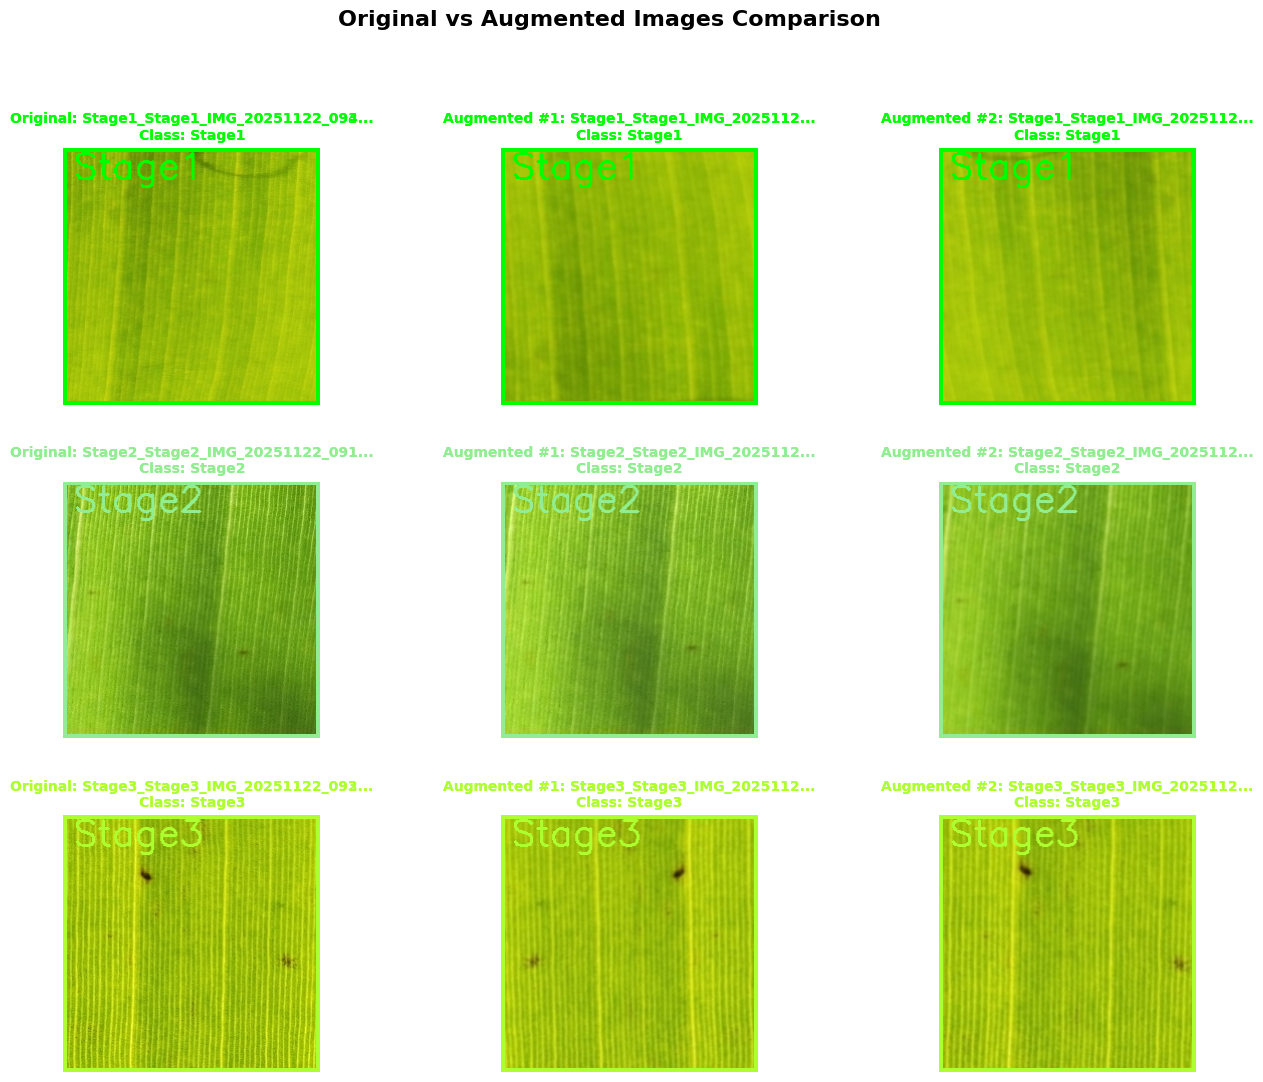


📈 AUGMENTATION STATISTICS

Stage1:
   Original: 146 images
   Augmented: 876 images
   Total: 1022 images
   Augmentation ratio: 6.0x

Stage2:
   Original: 145 images
   Augmented: 870 images
   Total: 1015 images
   Augmentation ratio: 6.0x

Stage3:
   Original: 145 images
   Augmented: 870 images
   Total: 1015 images
   Augmentation ratio: 6.0x


In [16]:
# Load combined training CSV to get augmented images
combined_train_csv = FINAL_DATASET_DIR / 'train' / 'labels' / 'train_labels_with_augmentation.csv'

if not combined_train_csv.exists():
    print("❌ Combined training CSV not found!")
    print("   Please run Cell 13 (Data Augmentation) first")
else:
    print("="*80)
    print("🖼️  VISUALIZING AUGMENTED IMAGES")
    print("="*80)

    # Load data
    combined_df = pd.read_csv(combined_train_csv)

    # Separate original and augmented images
    # Original images will have 'is_augmented' as NaN after concat if not explicitly set in the previous cell.
    original_df = combined_df[combined_df['is_augmented'].isna()]
    # Augmented images have 'is_augmented' explicitly set to True.
    augmented_df = combined_df[combined_df['is_augmented'] == True]

    print(f"\n📊 Dataset Summary:")
    print(f"   Original images: {len(original_df)}")
    print(f"   Augmented images: {len(augmented_df)}")
    print(f"   Total: {len(combined_df)}")

    if len(augmented_df) == 0:
        print("\n⚠️  No augmented images found!")
        print("   Please run Cell 13 (Data Augmentation) first")
    else:
        # Get sample images per class
        num_samples_per_class = 2  # Show 2 examples per class
        # Get all unique classes from the combined dataframe to ensure all classes are included
        classes = sorted(combined_df['class_label'].unique())

        print(f"\n📋 Showing {num_samples_per_class} examples per class")
        print(f"   Classes: {classes}")

        # Create visualization
        num_classes = len(classes)
        # Ensure num_classes is positive before creating GridSpec
        if num_classes == 0:
            print("\n⚠️  No classes found to visualize. Skipping visualization.")
        else:
            fig = plt.figure(figsize=(16, 4 * num_classes))
            gs = GridSpec(num_classes, 3, figure=fig, hspace=0.3, wspace=0.2)

            plot_idx = 0

            for class_idx, class_label in enumerate(classes):
                # Get original images for this class
                class_original = original_df[original_df['class_label'] == class_label]

                if len(class_original) == 0:
                    continue

                # Randomly select original images
                sample_original = class_original.sample(min(num_samples_per_class, len(class_original)), random_state=42)

                for sample_idx, (_, orig_row) in enumerate(sample_original.iterrows()):
                    # Get original image
                    orig_path = Path(orig_row['output_image_path'])

                    # Get corresponding augmented images
                    aug_images = augmented_df[
                        (augmented_df['class_label'] == class_label) &
                        (augmented_df.get('original_image', '') == orig_row['output_image_name'])
                    ]

                    if len(aug_images) == 0:
                        continue

                    # Read original image
                    orig_img = cv2.imread(str(orig_path))
                    if orig_img is None:
                        continue

                    # Draw bounding box with class color (whole image for classification)
                    h, w = orig_img.shape[:2]
                    class_color_bgr = CLASS_COLORS_RGB.get(class_label, (0, 0, 0))
                    # Draw bounding box around entire image
                    cv2.rectangle(orig_img, (0, 0), (w-1, h-1), class_color_bgr, thickness=5)
                    # Add class label text on image
                    cv2.putText(orig_img, class_label, (10, 30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1.2, class_color_bgr, 2)

                    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

                    # Plot original with class color
                    ax_orig = fig.add_subplot(gs[class_idx, 0])
                    ax_orig.imshow(orig_img)
                    class_color = CLASS_COLORS.get(class_label, 'black')  # Get color for class
                    ax_orig.set_title(f"Original: {orig_row['output_image_name'][:30]}...\nClass: {class_label}",
                                    fontsize=10, fontweight='bold', color=class_color)
                    ax_orig.axis('off')

                    # Plot augmented images (show first 2)
                    for aug_idx, (_, aug_row) in enumerate(aug_images.head(2).iterrows()):
                        aug_path = Path(aug_row['output_image_path'])

                        # Handle augmented image path
                        if not aug_path.exists():
                            aug_path = AUGMENTED_DIR / 'train' / 'images' / aug_row['output_image_name']

                        if aug_path.exists():
                            aug_img = cv2.imread(str(aug_path))
                            if aug_img is not None:
                                # Draw bounding box with class color on augmented image
                                h_aug, w_aug = aug_img.shape[:2]
                                class_color_bgr = CLASS_COLORS_RGB.get(class_label, (0, 0, 0))
                                # Draw bounding box around entire image
                                cv2.rectangle(aug_img, (0, 0), (w_aug-1, h_aug-1), class_color_bgr, thickness=5)
                                # Add class label text on image
                                cv2.putText(aug_img, class_label, (10, 30),
                                           cv2.FONT_HERSHEY_SIMPLEX, 1.2, class_color_bgr, 2)

                                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)

                                ax_aug = fig.add_subplot(gs[class_idx, aug_idx + 1])
                                ax_aug.imshow(aug_img)
                                class_color = CLASS_COLORS.get(class_label, 'black')  # Get color for class
                                ax_aug.set_title(f"Augmented #{aug_idx+1}: {aug_row['output_image_name'][:25]}...\nClass: {class_label}",
                                               fontsize=10, fontweight='bold', color=class_color)
                                ax_aug.axis('off')

            plt.suptitle('Original vs Augmented Images Comparison', fontsize=16, fontweight='bold', y=0.995)
            plt.tight_layout()
            plt.show()

        # Show statistics
        print(f"\n{'='*80}")
        print("📈 AUGMENTATION STATISTICS")
        print("="*80)

        for class_label in classes:
            class_orig = len(original_df[original_df['class_label'] == class_label])
            class_aug = len(augmented_df[augmented_df['class_label'] == class_label])
            total_class = class_orig + class_aug

            print(f"\n{class_label}:")
            print(f"   Original: {class_orig} images")
            print(f"   Augmented: {class_aug} images")
            print(f"   Total: {total_class} images")
            print(f"   Augmentation ratio: {class_aug / class_orig if class_orig > 0 else 0:.1f}x")

# **YOLO FORMAT** (cell 14-16)

In [17]:
YOLO_CLASSIFICATION_DIR = OUTPUT_DIR / 'yolo_classification_dataset'

# Create YOLO object detection format structure (images + labels folders)
# Structure: train/images/, train/labels/, valid/images/, valid/labels/, test/images/, test/labels/
splits = ['train', 'valid', 'test']

for split_name in splits:
    split_images_dir = YOLO_CLASSIFICATION_DIR / split_name / 'images'
    split_labels_dir = YOLO_CLASSIFICATION_DIR / split_name / 'labels'
    split_images_dir.mkdir(parents=True, exist_ok=True)
    split_labels_dir.mkdir(parents=True, exist_ok=True)

print(f"\n✅ YOLO dataset directory: {YOLO_CLASSIFICATION_DIR}")
print(f"   Structure: train/images/, train/labels/, valid/images/, valid/labels/, test/images/, test/labels/")

# Load CSVs - map to YOLO format splits (train, valid, test)
train_csv = FINAL_DATASET_DIR / 'train' / 'labels' / 'train_labels_with_augmentation.csv'
val_csv = FINAL_DATASET_DIR / 'validation' / 'labels' / 'validation_labels.csv'
test_csv = FINAL_DATASET_DIR / 'test' / 'labels' / 'test_labels.csv'

# Fallback to original CSVs if augmented don't exist
if not train_csv.exists():
    train_csv = FINAL_DATASET_DIR / 'train' / 'labels' / 'train_labels.csv'

print(f"\n📂 Loading split CSVs...")
print(f"   Train: {train_csv.exists()}")
print(f"   Validation: {val_csv.exists()}")
print(f"   Test: {test_csv.exists()}")

if not all([train_csv.exists(), val_csv.exists(), test_csv.exists()]):
    print("\n❌ ERROR: Split CSVs not found!")
    print("   Please run Cells 7-13 (data splitting + augmentation) first")
else:
    print("✅ All split CSVs found!")


✅ YOLO dataset directory: /content/drive/MyDrive/Machine_Learning/Data Labeling/yolo_classification_dataset
   Structure: train/images/, train/labels/, valid/images/, valid/labels/, test/images/, test/labels/

📂 Loading split CSVs...
   Train: True
   Validation: True
   Test: True
✅ All split CSVs found!


In [18]:
# Define splits mapping (map validation -> valid for YOLO format)
splits_mapping = {
    'train': train_csv,
    'valid': val_csv,  # YOLO uses 'valid' not 'validation'
    'test': test_csv
}

# Get all unique classes from all splits to create class mapping
all_classes = set()
for split_name, csv_path in splits_mapping.items():
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        all_classes.update(df['class_label'].unique())

# Define fixed class order: Healthy=0, Stage1=1, Stage2=2, ..., Stage6=6
FIXED_CLASS_ORDER = ['Healthy', 'Stage1', 'Stage2', 'Stage3', 'Stage4', 'Stage5', 'Stage6']

# Filter to only include classes that exist in the data, maintaining the fixed order
sorted_classes = [cls for cls in FIXED_CLASS_ORDER if cls in all_classes]

# Create mapping: 0=Healthy, 1=Stage1, 2=Stage2, etc.
class_to_id = {cls: idx for idx, cls in enumerate(sorted_classes)}
id_to_class = {idx: cls for cls, idx in class_to_id.items()}

print(f"\nClasses found: {sorted_classes}")
print(f"\nClass to ID mapping (Fixed Order):")
for cls, idx in class_to_id.items():
    print(f"   {idx}: {cls}")

# Process each split - create images/ and labels/ structure
for split_name, csv_path in splits_mapping.items():
    if not csv_path.exists():
        continue

    print(f"\n📦 Processing {split_name.upper()} split...")

    df = pd.read_csv(csv_path)

    # YOLO format directories
    yolo_images_dir = YOLO_CLASSIFICATION_DIR / split_name / 'images'
    yolo_labels_dir = YOLO_CLASSIFICATION_DIR / split_name / 'labels'

    copied_count = 0
    skipped_count = 0
    labels_created = 0

    # Process each image: copy to images/ and create .txt label file
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        try:
            # Get image path and class from CSV
            source_image_path = Path(row['output_image_path'])
            class_label = row['class_label']
            output_image_name = row['output_image_name']

            # Handle augmented images (they're in different directory)
            if not source_image_path.exists() and row.get('is_augmented', False):
                aug_path = AUGMENTED_DIR / 'train' / 'images' / output_image_name
                if aug_path.exists():
                    source_image_path = aug_path
                    logger.debug(f"Found augmented image: {aug_path}")

            if not source_image_path.exists():
                skipped_count += 1
                logger.warning(f"Image not found: {source_image_path}")
                continue

            # Copy image to YOLO images/ folder
            dest_image_path = yolo_images_dir / output_image_name
            shutil.copy2(source_image_path, dest_image_path)
            copied_count += 1

            # Create label file (.txt) in YOLO object detection format
            # Format: class_id center_x center_y width height (all normalized 0-1)
            # For whole-image classification: bounding box covers entire image
            class_id = class_to_id[class_label]
            label_filename = output_image_name.rsplit('.', 1)[0] + '.txt'  # Replace extension with .txt
            label_path = yolo_labels_dir / label_filename

            # YOLO format: class_id center_x center_y width height
            # For whole-image classification: center at (0.5, 0.5), full size (1.0, 1.0)
            center_x = 0.5  # Center of image (normalized)
            center_y = 0.5  # Center of image (normalized)
            width = 1.0      # Full width (normalized)
            height = 1.0     # Full height (normalized)

            with open(label_path, 'w') as f:
                # Write in YOLO format: class_id center_x center_y width height
                f.write(f"{class_id} {center_x} {center_y} {width} {height}\n")

            labels_created += 1

        except Exception as e:
            logger.error(f"Error processing {row.get('output_image_name', 'unknown')}: {e}")
            skipped_count += 1

    print(f"\n✅ {split_name.capitalize()} split:")
    print(f"   Images copied: {copied_count}")
    print(f"   Labels created: {labels_created}")
    print(f"   Skipped: {skipped_count}")

    # Show class distribution
    class_counts = df['class_label'].value_counts()
    print(f"\n   Class distribution:")
    for cls, count in class_counts.items():
        print(f"      {cls}: {count}")


Classes found: ['Stage1', 'Stage2', 'Stage3']

Class to ID mapping (Fixed Order):
   0: Stage1
   1: Stage2
   2: Stage3

📦 Processing TRAIN split...


Processing train: 100%|██████████| 3052/3052 [18:13<00:00,  2.79it/s]



✅ Train split:
   Images copied: 3052
   Labels created: 3052
   Skipped: 0

   Class distribution:
      Stage1: 1022
      Stage3: 1015
      Stage2: 1015

📦 Processing VALID split...


Processing valid: 100%|██████████| 94/94 [00:02<00:00, 46.40it/s]



✅ Valid split:
   Images copied: 94
   Labels created: 94
   Skipped: 0

   Class distribution:
      Stage3: 32
      Stage2: 31
      Stage1: 31

📦 Processing TEST split...


Processing test: 100%|██████████| 94/94 [00:02<00:00, 46.52it/s]


✅ Test split:
   Images copied: 94
   Labels created: 94
   Skipped: 0

   Class distribution:
      Stage2: 32
      Stage1: 31
      Stage3: 31


In [19]:
# Create YOLO data.yaml file (YOLO uses 'data.yaml' not 'dataset.yaml')
yolo_yaml_path = YOLO_CLASSIFICATION_DIR / 'data.yaml'

# YOLO format configuration
yolo_config = {
    'path': str(YOLO_CLASSIFICATION_DIR.absolute()),
    'train': 'train/images',  # Path to training images
    'val': 'valid/images',    # Path to validation images (YOLO uses 'valid' not 'validation')
    'test': 'test/images',     # Path to test images
    'names': id_to_class,      # {0: 'Stage1', 1: 'Stage2', 2: 'Stage3', ...}
    'nc': len(sorted_classes)  # Number of classes
}

with open(yolo_yaml_path, 'w') as f:
    yaml.dump(yolo_config, f, default_flow_style=False, sort_keys=False)

print(f"\n✅ YAML file created: {yolo_yaml_path}")
print(f"\n📋 Configuration:")
print(f"   Path: {yolo_config['path']}")
print(f"   Train: {yolo_config['train']}")
print(f"   Validation: {yolo_config['val']}")
print(f"   Test: {yolo_config['test']}")
print(f"   Number of classes: {yolo_config['nc']}")
print(f"   Classes: {list(yolo_config['names'].values())}")

print(f"\n📄 YAML file contents:")
with open(yolo_yaml_path, 'r') as f:
    print(f.read())

# Display dataset statistics
print(f"\n{'='*60}")
print(f"📊 DATASET STATISTICS")
print(f"{'='*60}")

for split_name in ['train', 'valid', 'test']:
    images_dir = YOLO_CLASSIFICATION_DIR / split_name / 'images'
    labels_dir = YOLO_CLASSIFICATION_DIR / split_name / 'labels'

    if images_dir.exists():
        images = list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.JPG')) + \
                 list(images_dir.glob('*.png')) + list(images_dir.glob('*.PNG'))
        labels = list(labels_dir.glob('*.txt'))

        print(f"\n📂 {split_name.upper()}:")
        print(f"   Images: {len(images)}")
        print(f"   Labels: {len(labels)}")

        if len(images) != len(labels):
            print(f"   ⚠️  Warning: Image/Label count mismatch!")

print(f"\n{'='*60}")
print(f"📁 Dataset location: {YOLO_CLASSIFICATION_DIR}")
print(f"   Config file: {yolo_yaml_path}")
print(f"\n✅ Next step: Train YOLO model")
print(f"   from ultralytics import YOLO")
print(f"   model = YOLO('yolov8n.pt')  # or yolov8s.pt, yolov8m.pt")
print(f"   model.train(data='{yolo_yaml_path}', epochs=100)")
print(f"\n   ⚠️  Note: Use yolov8n.pt (not yolov8n-cls.pt) for this format")


✅ YAML file created: /content/drive/MyDrive/Machine_Learning/Data Labeling/yolo_classification_dataset/data.yaml

📋 Configuration:
   Path: /content/drive/MyDrive/Machine_Learning/Data Labeling/yolo_classification_dataset
   Train: train/images
   Validation: valid/images
   Test: test/images
   Number of classes: 3
   Classes: ['Stage1', 'Stage2', 'Stage3']

📄 YAML file contents:
path: /content/drive/MyDrive/Machine_Learning/Data Labeling/yolo_classification_dataset
train: train/images
val: valid/images
test: test/images
names:
  0: Stage1
  1: Stage2
  2: Stage3
nc: 3


📊 DATASET STATISTICS

📂 TRAIN:
   Images: 3052
   Labels: 3052

📂 VALID:
   Images: 94
   Labels: 94

📂 TEST:
   Images: 94
   Labels: 94

📁 Dataset location: /content/drive/MyDrive/Machine_Learning/Data Labeling/yolo_classification_dataset
   Config file: /content/drive/MyDrive/Machine_Learning/Data Labeling/yolo_classification_dataset/data.yaml

✅ Next step: Train YOLO model
   from ultralytics import YOLO
   model